In [3]:
import sys 
sys.path.insert(0, "/gpfswork/rech/omr/uen17sn/SpinUp/lib/")
import pp_test as pp
import mg_test as mg
import Optimization as opti

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import math
import pandas as pd
from multiprocessing import Pool

import joblib
from joblib import Parallel, delayed, parallel_backend

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## TEMPERATURE

### *Visualisation du dataset*

In [4]:
thetaoDataset = xr.open_dataset("data/CM65v420-LR-SKL-pi-05_18500101_19491231_1M_thetao.nc",decode_times=True)
soDataset     = xr.open_dataset("data/CM65v420-LR-SKL-pi-05_18500101_19491231_1M_so.nc",decode_times=True)

In [5]:
thetaoDataset

<xarray.Dataset>
Dimensions:               (y: 331, x: 360, deptht: 75, time_counter: 1200,
                           axis_nbounds: 2)
Coordinates:
    nav_lat               (y, x) float32 ...
    nav_lon               (y, x) float32 ...
  * deptht                (deptht) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    time_centered         (time_counter) datetime64[ns] ...
  * time_counter          (time_counter) datetime64[ns] 1850-01-16T12:00:00 ....
Dimensions without coordinates: y, x, axis_nbounds
Data variables:
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] ...
    thetao                (time_counter, deptht, y, x) float32 ...
Attributes:
    name:                      CM65v420-LR-SKL-pi-05_1m_grid_T
    description:               Created by xios
    title:                     Created by xios
    Conventions:               CF-1.6
    timeStamp:                 2022-May-10 14:51:19 GMT
    uuid:                      864cf418-542c-468f-a9a5-f5b342d40663
    LongName:                  IPSLCM6.5.0-LR
    history:                   Wed May 11 07:27:45 2022: ncrcat -C --buffer_s...
    NCO:                       "4.6.0"
    nco_openmp_thread_number:  1

## SEPARTION EN MODE

### *1D temperature and salinity function*

In [6]:
thetao_z = thetaoDataset.thetao[0:20].mean(dim=["time_counter","x","y"],skipna=True)
so_z     = soDataset.so[0:20].mean(dim=["time_counter","x","y"],skipna=True)

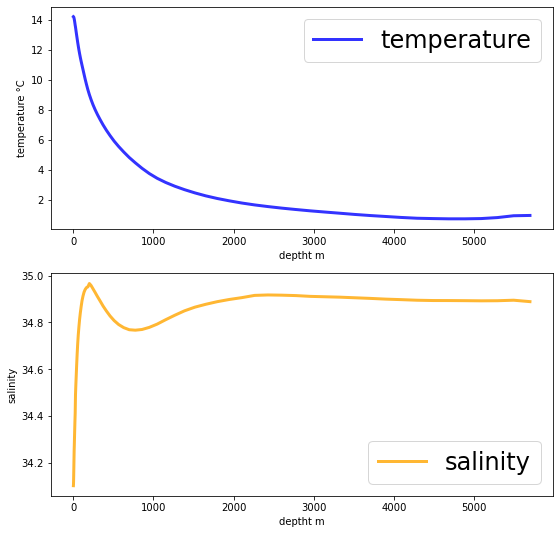

In [8]:
fig, ax = plt.subplots(2,figsize=(9,9))
ax[0].plot(thetao_z.deptht,thetao_z,color="blue",alpha=0.8, linewidth=3,label="temperature")
ax[0].set_xlabel("deptht m")
ax[0].set_ylabel("temperature °C")

ax[1].plot(so_z.deptht,so_z,color="orange",alpha=0.8,linewidth=3,label="salinity")
ax[1].set_ylabel("salinity")
ax[1].set_xlabel("deptht m")
ax[1].legend(fontsize=24)
ax[0].legend(fontsize=24)
plt.show()

Extend value to project on the Z dimensions

p=np.array(temp1D.deptht)
temp_ext=[temperature[0]]*round(p[0])
for i in range(1,len(p)):
    temp_ext.extend([temperature[i]]*round(p[i]-p[i-1]))

In [9]:
def extend_values(var,depth): #var.values #var.deptht.values
    result = [0]*round(depth[-1])
    for i in range(1,len(var)):
        b1 = round(depth[i-1])
        b2 = round(depth[i])
        result[b1:b2] = [var[i-1]]*(b2-b1)
    return np.array(result[1:])

In [10]:
new_thetao=extend_values(thetao_z.values,thetao_z.deptht.values)
new_so=extend_values(so_z.values,so_z.deptht.values)

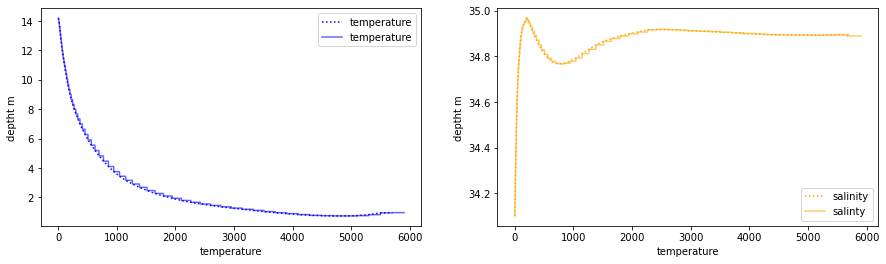

In [11]:
fig, ax = plt.subplots(1,2,figsize=(15,4))
ax[0].plot(thetao_z.deptht,thetao_z,linestyle="dotted",markersize=6,color="blue",label="temperature")
ax[0].plot(new_thetao,color="blue",alpha=0.6, label="temperature")
ax[0].set_xlabel("temperature")
ax[0].set_ylabel("deptht m")

ax[1].plot(so_z.deptht,so_z,linestyle="dotted",markersize=6,color="orange",label="salinity")
ax[1].plot(new_so,color="orange", alpha=0.6,label="salinty")
ax[1].set_xlabel("temperature")
ax[1].set_ylabel("deptht m")
ax[1].legend()
ax[0].legend()
plt.show()

### *Separation in mode*

Work with the anomaly value

In [12]:
thetao = new_thetao - np.nanmean(new_thetao)
so     = new_so     - np.nanmean(new_so)

#### - 1st mode

In [13]:
def variance(point,serie):
    s1,s2 =serie[:point],serie[point:]
    v1 = np.sqrt(np.nansum((s1 - np.nanmean(s1)) ** 2))
    v2 = np.sqrt(np.nansum((s2 - np.nanmean(s2)) ** 2))
    return v1+v2

def min_var(serie,n_modes):
    variances = [variance(i,serie) for i in range(len(serie))]
    p = np.argmin(np.array(variances))
    if n_modes == 0:
        return (n_modes,p)
    else:
        v1,v2 = serie[:p],serie[p:]
        return (n_modes,p),min_var(v1,n_modes = n_modes-1), min_var(v2,n_modes = n_modes-1)

In [14]:
print("mode 1:",min_var(thetao,0))
print("mode 2:",min_var(so,0))

/tmp/ipykernel_2760542/3667009880.py:3: RuntimeWarning: Mean of empty slice
  v1 = np.sqrt(np.nansum((s1 - np.nanmean(s1)) ** 2))


mode 1: (0, 856)
mode 2: (0, 26)


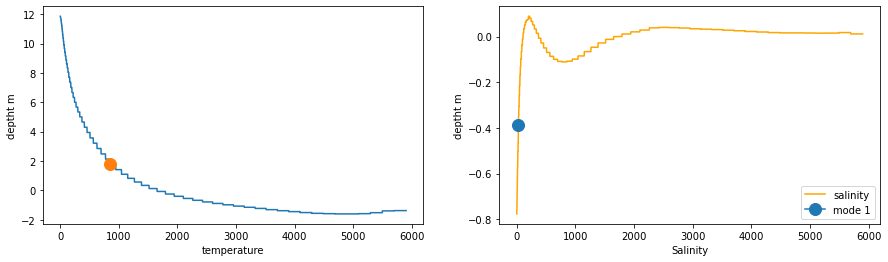

In [15]:
fig, ax = plt.subplots(1,2,figsize=(15,4))
ax[0].plot(thetao,label="temperature")
ax[0].plot(856,thetao[856], marker="o", markersize=12,label="mode 1")
ax[0].set_xlabel("temperature")
ax[0].set_ylabel("deptht m")

ax[1].plot(so,color="orange",label="salinity")
ax[1].plot(26,so[26], marker="o", markersize=12,label="mode 1")
ax[1].set_xlabel("Salinity")
ax[1].set_ylabel("deptht m")
ax[1].legend()
plt.show()

#### - 2nd mode

In [16]:
def variance2(serie,p1,p2): #[0,1,2,len(serie)-1]
    s1 = serie[0:p1]
    s2 = serie[p1:p2]
    s3 = serie[p2:len(serie)]
    v  = [np.sqrt(np.nansum((s - np.nanmean(s)) ** 2)) for s in [s1,s2,s3]]
    return np.sum(v)
                 
                 
def minVar2(serie):
    var = np.full((len(serie),len(serie)),1000)
    for i in range(1,len(serie)-2):
        var[i,i+1:-1] = np.array(Parallel(n_jobs=100)(delayed(variance2)(serie,i,j) for j in range(i+1,len(serie)-1)))
    return var

v=[]
a=[variance2(thetao,1,j) for j in range(1+1,len(thetao))]

a=minVar2(thetao)
b=minVar2(so)

plt.pcolor(a[::5,::5]) 
plt.colorbar()

minT = np.unravel_index(np.argmin(a), a.shape)
minS = np.unravel_index(np.argmin(b), b.shape)
print(minT)
print(minS)

#plt.pcolor(b[::5,::5]) 
#plt.colorbar()

In [17]:
#v=[]
#test=thetao[::100]
#for i in range(1,len(thetao)-1):
#    v.append(list(Parallel(n_jobs=100)(delayed(variance2)(thetao,i,j) for j in range(i+1,len(thetao),100))))

#mini1 = [np.argmin(v[i]) for i in range(len(v))]
#print("minimum point 1",np.argmin(mini1))
#mini2 = np.min(mini1)
#print("minimum point 2",np.argmin(mini2))

### *Apply to all data*

In [18]:
def meanStrat(sim,var): 
    dataset = xr.open_dataset(sim,chunks={"time_counter": 100},decode_times=False)
    var = dataset[var].mean("deptht").load()
    return var.values

In [19]:
def meanStrat1(sim,var,d):
    dataset = xr.open_dataset(sim,chunks={"time_counter": 100},decode_times=False)
    var1 = dataset[var].sel(deptht=slice(None, d)).mean("deptht").load()
    var2 = dataset[var].sel(deptht=slice(d, None)).mean("deptht").load()
    return var1.values,var2.values

In [20]:
def meanStrat2(sim,var,d1,d2):
    dataset = xr.open_dataset(sim,chunks={"time_counter": 100},decode_times=False)
    var1 = dataset[var].sel(deptht=slice(None, d1)).mean("deptht").load()
    var2 = dataset[var].sel(deptht=slice(d1, d2)).mean("deptht").load()
    var3 = dataset[var].sel(deptht=slice(d2, None)).mean("deptht").load()
    return var1.values,var2.values,var3.values

In [21]:
simt=["data/CM65v420-LR-SKL-pi-05_18500101_19491231_1M_thetao.nc",
     "data/CM65v420-LR-SKL-pi-05_19500101_20491231_1M_thetao.nc",
     "data/CM65v420-LR-SKL-pi-05_20500101_21491231_1M_thetao.nc",
     "data/CM65v420-LR-SKL-pi-05_21500101_22491231_1M_thetao.nc",
     "data/CM65v420-LR-SKL-pi-05_22500101_23491231_1M_thetao.nc"]

sims=["data/CM65v420-LR-SKL-pi-05_18500101_19491231_1M_so.nc",
     "data/CM65v420-LR-SKL-pi-05_19500101_20491231_1M_so.nc",
     "data/CM65v420-LR-SKL-pi-05_20500101_21491231_1M_so.nc",
     "data/CM65v420-LR-SKL-pi-05_21500101_22491231_1M_so.nc",
     "data/CM65v420-LR-SKL-pi-05_22500101_23491231_1M_so.nc"]

In [39]:
result_t=Parallel(n_jobs=3)(delayed(meanStrat)(simt[i],"thetao") for i in range(5))
result_s=Parallel(n_jobs=3)(delayed(meanStrat)(sims[i],"so") for i in range(5))

result_t1=Parallel(n_jobs=3)(delayed(meanStrat1)(simt[i],"thetao",856) for i in range(5))
result_s1=Parallel(n_jobs=3)(delayed(meanStrat1)(sims[i],"so",26) for i in range(5))

/linkhome/rech/genloc01/uen17sn/.local/lib/python3.9/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/linkhome/rech/genloc01/uen17sn/.local/lib/python3.9/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/linkhome/rech/genloc01/uen17sn/.local/lib/python3.9/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/linkhome/rech/genloc01/uen17sn/.local/lib/python3.9/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeW

In [46]:
print(np.shape(result_t))
print(np.shape(result_t1))
print(np.shape(np.array(result_t1)[:,0]))

(5, 1200, 331, 360)
(5, 2, 1200, 331, 360)
(5, 1200, 331, 360)


In [ ]:
np.save('backup/thetao0.npy',result_t)
np.save('backup/thetao1.npy',result_t1)
np.save('backup/so0.npy',result_)
np.save('backup/so1.npy',temp_mode2_arr)

In [4]:
result_t  = np.load('backup/thetao0.npy')
result_t1 = np.load('backup/thetao1.npy')
result_s = np.load('backup/so0.npy')
result_s1 = np.load('backup/so1.npy')

In [5]:
thetao0 = np.array(result_t).reshape(len(simt)*-1,331,360)
so0     = np.array(result_s).reshape(len(sims)*-1,331,360)

thetao1_1 = np.array(result_t1)[:,0,:,:].reshape(len(simt)*-1,331,360)
#thetao1_2 = np.array(result_t1)[:,1,:,:].reshape(len(simt)*-1,331,360)
so1_1     = np.array(result_s1)[:,0,:,:].reshape(len(sims)*-1,331,360)
#so1_2     = np.array(result_s1)[:,1,:,:].reshape(len(sims)*-1,331,360)

print("shape of each mode:",np.shape(thetao0))

shape of each mode: (6000, 331, 360)


____

## Preprocessing

In [6]:
dataset_thetao = pp.SimulationBatch([thetao0,thetao1_1])#thetao1_2
dataset_so= pp.SimulationBatch([so0,so1_1])#so1_2

print("Shape of datasets:")
[print(f"{i} : {dataset_so.simulations[i].shape}") for i in range(len(dataset_so.simulations))];

Shape of datasets:
0 : (6000, 331, 360)
1 : (6000, 331, 360)


### *Data Conversion*

In [7]:
dataset_thetao.prepare(ssca=True,period=12,weight=False,norm="pointwise_stats")
dataset_so.prepare(ssca=True,period=12,weight=False,norm="pointwise_stats")

In [8]:
print("Shape of datasets:")
[print(f"{i} : {dataset_so.simulations[i].shape}") for i in range(len(dataset_so.simulations))];

Shape of datasets:
0 : (500, 331, 360)
1 : (500, 331, 360)


### *PCA*

In [10]:
n_comp=20

print("Simulations before pca: \n")
[print(f"{sim.shape}, type:{sim.dtype}") for sim in dataset_so.masked_simulations];

dataset_so.compute_pca2(n_comp, transform=True,to_torch=True,norm=True)
dataset_thetao.compute_pca2(n_comp, transform=True,to_torch=True,norm=True)

print("\nSimulations after pca: \n")
[print(f"{sim.shape}, type:{sim.dtype}") for sim in dataset_so.masked_simulations];
#[print(f"{sim.shape}, type:{sim.dtype}") for sim in dataset.project_simulations];

Simulations before pca: 

(500, 65294), type:float32
(500, 65294), type:float32

Simulations after pca: 

torch.Size([500, 20]), type:torch.float32
torch.Size([500, 20]), type:torch.float32


salinity
total :  75.645485
total :  66.59754



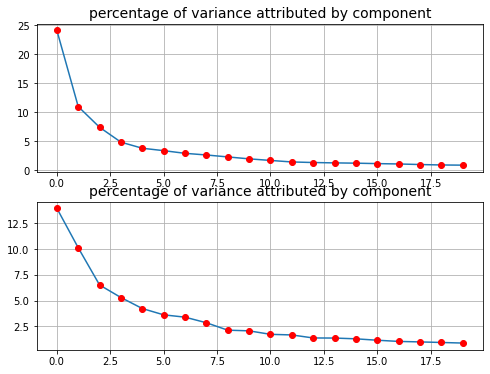

temperature
total :  71.87959
total :  72.48989


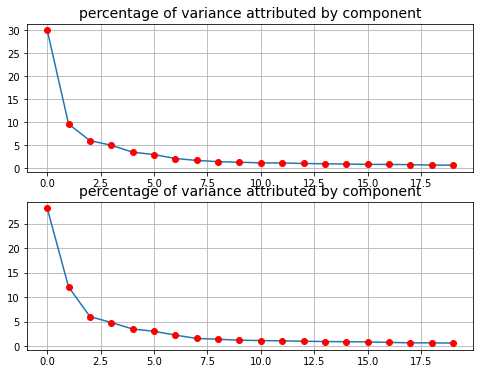

In [13]:
print("salinity")
dataset_so.plot_variance_ratio()
print()
plt.show()
print("temperature")
dataset_thetao.plot_variance_ratio()

barotropic salinity


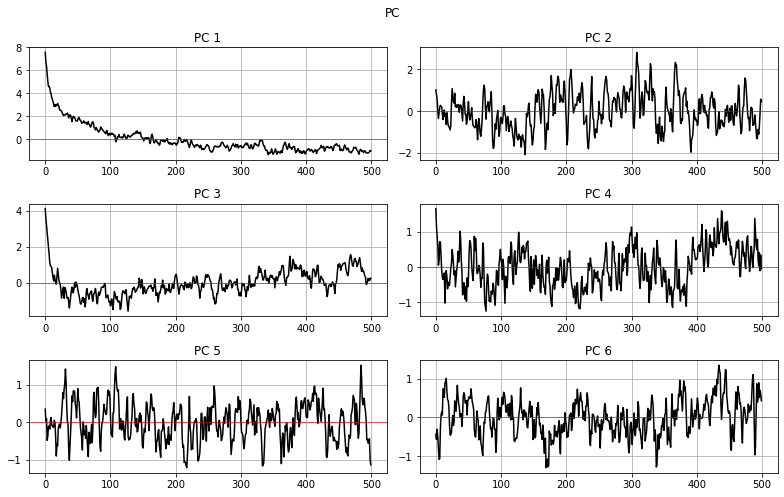

mode1 surface salinity


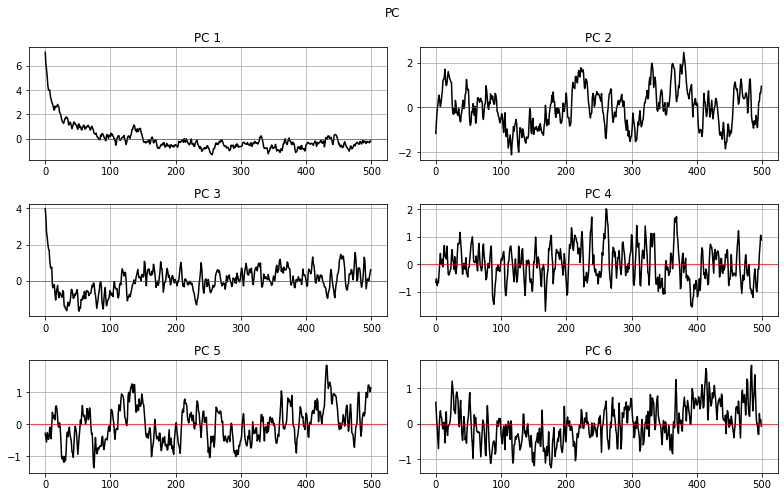

In [16]:
print("barotropic salinity")
dataset_so.plot_eof(0)
plt.show()
print("mode1 surface salinity")
dataset_so.plot_eof(1)

barotropic salinity


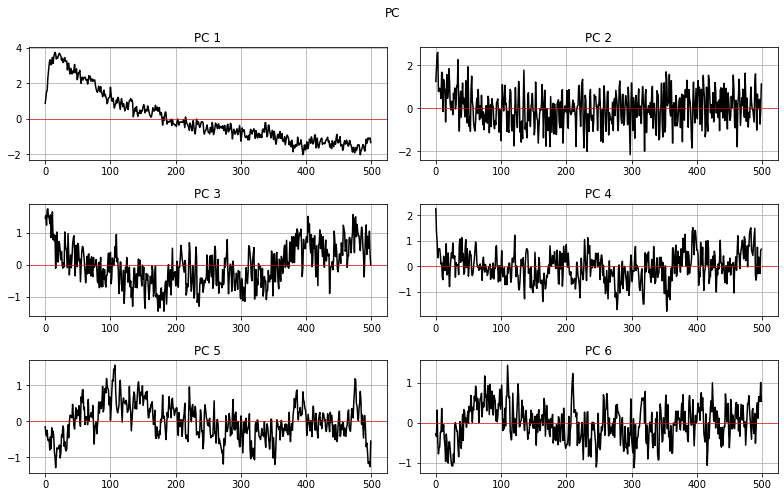

mode1 surface salinity


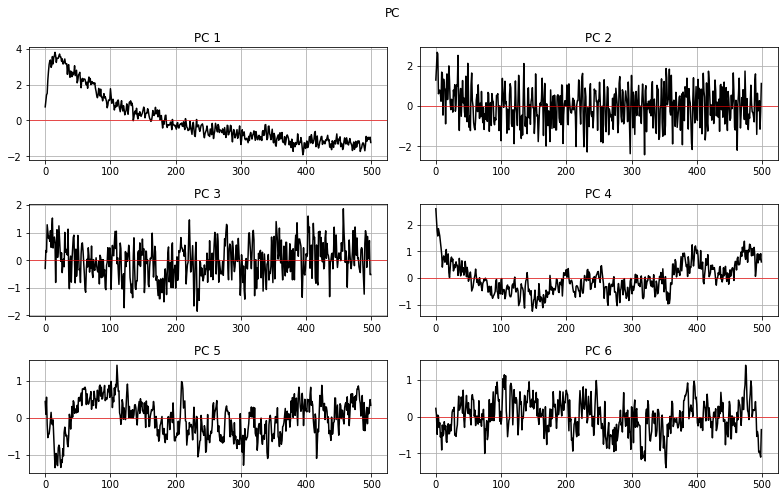

In [17]:
print("barotropic temperature")
dataset_thetao.plot_eof(0)
plt.show()
print("mode1 surface temperature")
dataset_thetao.plot_eof(1)

## Autre

In [2]:
var_thetao="thetao"
sim_thetao=["CM65v420-LR-SKL-pi-05_18500101_19491231_1M_thetao.nc",
            "CM65v420-LR-SKL-pi-05_19500101_20491231_1M_thetao.nc",
            "CM65v420-LR-SKL-pi-05_20500101_21491231_1M_thetao.nc",
            "CM65v420-LR-SKL-pi-05_21500101_22491231_1M_thetao.nc",
            "CM65v420-LR-SKL-pi-05_22500101_23491231_1M_thetao.nc"]
"""

var_so="so"
sim_so=["CM65v420-LR-SKL-pi-05_18500101_19491231_1M_so.nc",
        "CM65v420-LR-SKL-pi-05_19500101_20491231_1M_so.nc",
        "CM65v420-LR-SKL-pi-05_20500101_21491231_1M_so.nc",
        "CM65v420-LR-SKL-pi-05_21500101_22491231_1M_so.nc",
        "CM65v420-LR-SKL-pi-05_22500101_23491231_1M_so.nc"]


var_zos="zos"
sim_zos=["CM65v420-LR-SKL-pi-05_18500101_19491231_1M_zos.nc",
         "CM65v420-LR-SKL-pi-05_19500101_20491231_1M_zos.nc",
         "CM65v420-LR-SKL-pi-05_20500101_21491231_1M_zos.nc",
         "CM65v420-LR-SKL-pi-05_21500101_22491231_1M_zos.nc",
         "CM65v420-LR-SKL-pi-05_22500101_23491231_1M_zos.nc"]

pref="../../simu/temp/data/"
dim="time_counter"